In [2]:
import boto3
import sagemaker
import time
from time import strftime

boto_session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=boto_session)
sm_client = boto3.client("sagemaker")
region = boto_session.region_name
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
account = sagemaker_session.boto_session.client("sts").get_caller_identity()["Account"]

prefix = "sagemaker-flower-dvc"

print(f"account: {account}")
print(f"bucket: {bucket}")
print(f"region: {region}")
print(f"role: {role}")

account: 006547668672
bucket: sagemaker-ap-south-1-006547668672
region: ap-south-1
role: arn:aws:iam::006547668672:role/service-role/AmazonSageMaker-ExecutionRole-20221123T080657


In [14]:
from sagemaker.pytorch import PyTorchPredictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

In [15]:
predictor_new = PyTorchPredictor(
    endpoint_name="test-project-2-staging",
    sagemaker_session=sagemaker_session,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

In [16]:
classnames = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

In [4]:
! wget -O daisy.jpg "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/marguerite-daisy-types-1586981163.jpg"

--2022-12-08 06:00:00--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/marguerite-daisy-types-1586981163.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.152.155
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.152.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158008 (154K) [image/jpeg]
Saving to: ‘daisy.jpg’

daisy.jpg           100%[===================>] 154.30K  --.-KB/s    in 0.005s  

2022-12-08 06:00:00 (28.2 MB/s) - ‘daisy.jpg’ saved [158008/158008]



In [5]:
import torch

import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
daisy_im = Image.open("daisy.jpg")

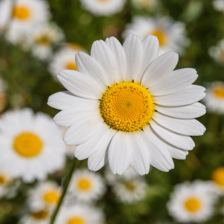

In [7]:
daisy_im.resize((224, 224))

In [8]:
transforms = T.Compose(
    [
        T.ToTensor(),
        T.Resize((224, 224)),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [9]:
daisy_img_t = transforms(daisy_im)

In [10]:
daisy_input = {"inputs": daisy_img_t[None, ...].numpy().tolist()}

In [17]:
out = predictor_new.predict(daisy_input)

In [18]:
out

[[0.0,
  -18.984155654907227,
  -25.680252075195312,
  -21.003122329711914,
  -26.21082305908203]]

In [19]:
out_t = torch.tensor(out)

In [20]:
F.softmax(out_t, dim=-1)

tensor([[1.0000e+00, 5.6923e-09, 7.0341e-12, 7.5589e-10, 4.1379e-12]])

In [21]:
f"Prediction: {classnames[torch.argmax(out_t, dim=-1)[0]]}"

'Prediction: daisy'